In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utilities.graphing_utils as utl

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df['bmi'].fillna(df['bmi'].median(), inplace = True) #fill na with median

In [4]:
#dropping 'other' gender instance due to one-off outlier
df.drop(df.index[df['gender'] == 'Other'], inplace = True)


In [5]:
#processing smoking as an ordinal categorical variable
df["smoking_status"]=df["smoking_status"].map({"Unknown": 0,"never smoked" : 1,"formerly smoked" : 2,"smokes" : 3})

In [6]:
#get dummies for rest of categorical features
df = pd.get_dummies(df, drop_first=True)

## Modeling

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [8]:
#declaring features and target variable. Using features with highest and lowest correlation to target variable Attrition
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size= 0.4)

In [9]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [10]:
rfc = RandomForestClassifier(max_depth=6)
rfc.fit(Xs_train, y_train)
rfc.score(Xs_train, y_train), rfc.score(Xs_test, y_test)

(0.9523654159869495, 0.9510763209393346)

In [11]:
d = {'Column Name':X_train.columns,'Feature Importance':rfc.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.324107
3,avg_glucose_level,0.239415
4,bmi,0.158838
5,smoking_status,0.059027
2,heart_disease,0.050318
1,hypertension,0.048647
7,ever_married_Yes,0.033822
9,work_type_Private,0.020984
12,Residence_type_Urban,0.020050
6,gender_Male,0.019840


In [12]:
def get_metrics(test_model):
    y_pred = test_model.predict(Xs_test)
    recall = round(recall_score(y_test, y_pred),2)
    accuracy = round(accuracy_score(y_test, y_pred),2)
    print(f'Recall score for this data {recall},\nAccuracy score for this data is {accuracy}')
    
    return plot_confusion_matrix(test_model, Xs_test, y_test, cmap='inferno')


Recall score for this data 0.0,
Accuracy score for this data is 0.95


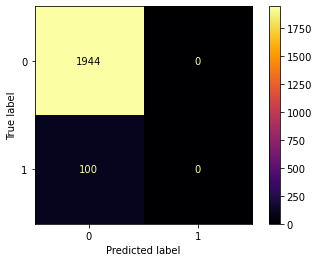

In [13]:
get_metrics(rfc);

### Modeling with Smote due to imbalanced classes

In [14]:
#reference: https://git.generalassemb.ly/plarkin13/8.07-imbalanced-data/blob/master/H_imbalanced_classes_solutions.ipynb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from imblearn.pipeline import Pipeline

smo = SMOTE()

Xs_train_smote, y_train_smote = smo.fit_resample(Xs_train, y_train)

#print_sampling_stats(Xs_train, X_train_smote, y_train, y_train_smote,y_test)

In [15]:
Xs_test.shape

(2044, 13)

In [16]:
y_test.shape

(2044,)

In [17]:
y_train_smote.shape

(5832,)

In [18]:
Xs_train_smote.shape

(5832, 13)

In [19]:
rfc_smote = RandomForestClassifier(max_depth=6)
rfc_smote.fit(Xs_train_smote, y_train_smote)
rfc_smote.score(Xs_train_smote, y_train_smote), rfc_smote.score(Xs_test, y_test)

(0.8657407407407407, 0.7216242661448141)

In [20]:
d = {'Column Name': X_train.columns,'Feature Importance':rfc_smote.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.487250
5,smoking_status,0.141556
7,ever_married_Yes,0.113671
4,bmi,0.080226
3,avg_glucose_level,0.041329
1,hypertension,0.029853
2,heart_disease,0.023887
11,work_type_children,0.022686
12,Residence_type_Urban,0.019791
6,gender_Male,0.016144


In [21]:
print(classification_report(y_test, rfc_smote.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1944
           1       0.11      0.66      0.19       100

    accuracy                           0.72      2044
   macro avg       0.54      0.69      0.51      2044
weighted avg       0.93      0.72      0.80      2044



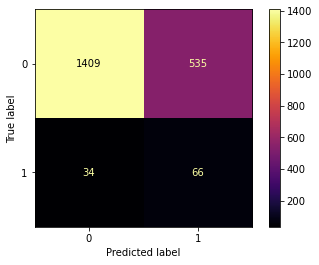

In [22]:
plot_confusion_matrix(rfc_smote, Xs_test, y_test, cmap='inferno');

### Modeling with RandomOversampler due to imbalanced classes

In [23]:
ros = RandomOverSampler()
Xs_train_over, y_train_over = ros.fit_resample(Xs_train, y_train)

"""print_sampling_stats(Xs_train, X_train_over,
                     y_train, y_train_over,
                     y_test)"""

rfc_ros = RandomForestClassifier(max_depth=6)
rfc_ros.fit(Xs_train_over, y_train_over)
rfc_ros.score(Xs_train_over, y_train_over), rfc_ros.score(Xs_test, y_test)

(0.8515089163237312, 0.7040117416829745)

In [24]:
d = {'Column Name': X_train.columns,'Feature Importance':rfc_ros.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.547782
4,bmi,0.103099
3,avg_glucose_level,0.101370
7,ever_married_Yes,0.073680
11,work_type_children,0.046914
1,hypertension,0.040096
2,heart_disease,0.035785
5,smoking_status,0.022872
10,work_type_Self-employed,0.010521
12,Residence_type_Urban,0.006549


In [25]:
print(classification_report(y_test, rfc_ros.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1944
           1       0.12      0.77      0.20       100

    accuracy                           0.70      2044
   macro avg       0.55      0.74      0.51      2044
weighted avg       0.94      0.70      0.79      2044



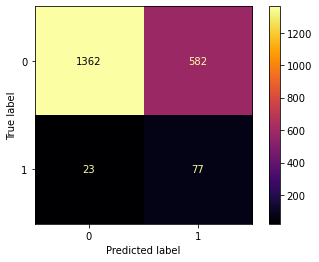

In [26]:
plot_confusion_matrix(rfc_ros, Xs_test, y_test, cmap='inferno');

### Random UnderSampler:

In [27]:
rus = RandomUnderSampler()

Xs_train_under, y_train_under = rus.fit_resample(Xs_train, y_train)

'''print_sampling_stats(Xs_train, X_train_under,
                    y_train, y_train_under,
                    y_test)'''

rfc_rus = RandomForestClassifier(max_depth=10)
rfc_rus.fit(Xs_train_under, y_train_under)
rfc_rus.score(Xs_train_under, y_train_under), rfc_rus.score(Xs_test, y_test)

(1.0, 0.6829745596868885)

In [28]:
print(classification_report(y_test, rfc_rus.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.99      0.68      0.80      1944
           1       0.11      0.80      0.20       100

    accuracy                           0.68      2044
   macro avg       0.55      0.74      0.50      2044
weighted avg       0.94      0.68      0.77      2044



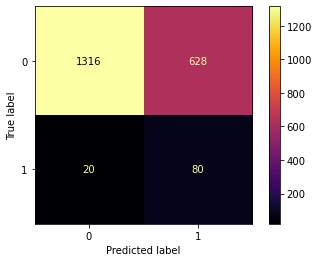

In [29]:
plot_confusion_matrix(rfc_rus, Xs_test, y_test, cmap='inferno');

# Trying Different Models

- Random Forest Classifier
- Logistic Regression
- Support Vector Machine (SVM)
- K Nearest Neighbor
- Decision Tree
- Extremely Randomized Trees (ExtraTrees)
- Naive Bayes
- XGBoost
- Possible neural network for tinkering purposes

#### Logistic regression

In [30]:
from sklearn.linear_model import LogisticRegression
lr_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('lr', LogisticRegression(max_iter = 5000))
    ])

lr_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5],
    'lr__C': [0.001, 0.01],
    'lr__class_weight': ['balanced', 'auto', None]
    
}
lr_gs = RandomizedSearchCV(lr_pipe, lr_pipe_params, scoring = 'recall', cv = 3)
lr_gs.fit(X_train, y_train)
lr_preds_gs = lr_gs.predict(X_test)
lr_gs.best_params_


{'sampling__sampling_strategy': 'auto',
 'sampling__k_neighbors': 5,
 'lr__class_weight': 'balanced',
 'lr__C': 0.001}

Recall score for this data 0.15,
Accuracy score for this data is 0.92


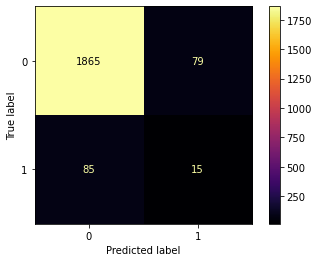

In [31]:
get_metrics(lr_gs);

#### Decision Tree
https://git.generalassemb.ly/DSI-R-628/6.02-bootstrapping-bagging/blob/master/sols.ipynb

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
dt_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('dt', DecisionTreeClassifier(random_state = 42, class_weight= 'balanced')) #adding class weight due to imbalanced target data
    ])

dt_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5],
    'dt__max_depth': [None, 3, 5],
    'dt__min_samples_split': [3,4,5],
    'dt__min_samples_leaf' : [1,2],
    
}
dt_gs = RandomizedSearchCV(dt_pipe, dt_pipe_params, scoring = 'recall', cv = 3)
dt_gs.fit(X_train, y_train)
dt_preds_gs = dt_gs.predict(X_test)
dt_gs.best_params_

{'sampling__sampling_strategy': 'auto',
 'sampling__k_neighbors': 3,
 'dt__min_samples_split': 4,
 'dt__min_samples_leaf': 2,
 'dt__max_depth': 3}

Recall score for this data 0.0,
Accuracy score for this data is 0.95


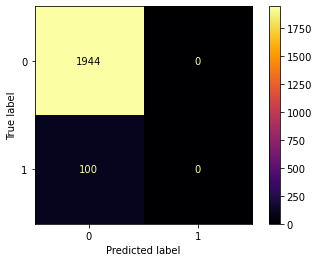

In [33]:
get_metrics(dt_gs);

#### Extremely Randomized Trees (ExtraTrees)
https://git.generalassemb.ly/DSI-R-628/6.03-random-forest-extra-trees/blob/master/Random_Forest_Extra_Trees_sols.ipynb

In [34]:
from sklearn.ensemble  import ExtraTreesClassifier

extt_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('dt', DecisionTreeClassifier(random_state = 42, class_weight= 'balanced')) #adding class weight due to imbalanced target data
    ])

extt_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5],
    'dt__max_depth': [None, 3, 5],
    'dt__min_samples_split': [3,4,5],
    'dt__min_samples_leaf' : [1,2],
    
}
extt_gs = RandomizedSearchCV(extt_pipe, extt_pipe_params, scoring = 'recall', cv = 3)
extt_gs.fit(X_train, y_train)
extt_preds_gs = extt_gs.predict(X_test)
extt_gs.best_params_

{'sampling__sampling_strategy': 0.75,
 'sampling__k_neighbors': 3,
 'dt__min_samples_split': 4,
 'dt__min_samples_leaf': 1,
 'dt__max_depth': 3}

Recall score for this data 0.0,
Accuracy score for this data is 0.95


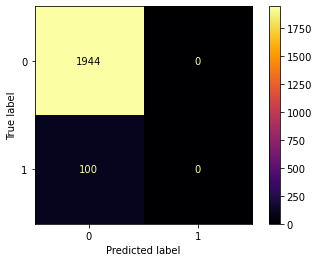

In [35]:
get_metrics(extt_gs);

#### Support Vector Machine (SVM)
https://git.generalassemb.ly/DSI-R-628/6.06-lesson-svms/blob/master/solution-code/solution-code.ipynb

In [36]:
from sklearn.svm import SVC
svc_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('svc', SVC(gamma="scale"))
    ])

svc_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5],
    'svc__C': [0.001, 0.01],
    'svc__kernel': ['rbf', 'sigmoid']
    
}
svc_gs = RandomizedSearchCV(svc_pipe, svc_pipe_params, scoring = 'recall', cv = 3)
svc_gs.fit(X_train, y_train)
svc_preds_gs = svc_gs.predict(X_test)
svc_gs.best_params_

{'svc__kernel': 'rbf',
 'svc__C': 0.001,
 'sampling__sampling_strategy': 'auto',
 'sampling__k_neighbors': 3}

Recall score for this data 1.0,
Accuracy score for this data is 0.05


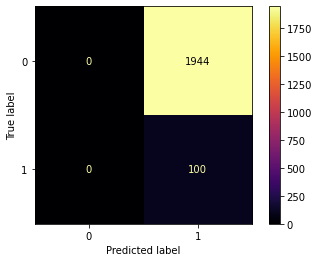

In [37]:
get_metrics(svc_gs);

#### K Nearest Neighbor (KNN)
https://git.generalassemb.ly/DSI-R-628/4.03-knn/blob/master/KNN-sols.ipynb

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('knn', KNeighborsClassifier())
    ])

knn_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3,5,7],
    'knn__p' : [1,2]
    
}
knn_gs = RandomizedSearchCV(knn_pipe, knn_pipe_params, scoring = 'recall', cv = 3)
knn_gs.fit(X_train, y_train)
knn_preds_gs = knn_gs.predict(X_test)
knn_gs.best_params_

{'sampling__sampling_strategy': 'auto',
 'sampling__k_neighbors': 5,
 'knn__weights': 'uniform',
 'knn__p': 2,
 'knn__n_neighbors': 7}

Recall score for this data 0.08,
Accuracy score for this data is 0.92


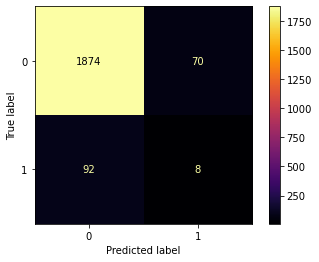

In [39]:
get_metrics(knn_gs);

#### Naive Bayes (not used since it is unable to handle negative numbers within features)


#### XGBoost
- intro-to-boosting-solution.ipynb https://git.generalassemb.ly/DSI-R-628/6.05-lesson-boosting

- params for xgboost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [40]:
#from xgboost import XGBClassifier
xgb_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('xgb', XGBClassifier(use_label_encoder=False))
    ])

xgb_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5]
    
}
xgb_gs = RandomizedSearchCV(xgb_pipe, xgb_pipe_params, scoring = 'recall', cv = 3)
xgb_gs.fit(X_train, y_train)
xgb_gs = xgb_gs.predict(X_test)
print("Best Score: ", xgb_gs.best_score_)
print("Best Params: ", xgb_gs.best_params_)
get_metrics(xgb_gs);

NameError: name 'XGBClassifier' is not defined

#### Possible neural network

In [41]:
print(Xs_train.shape, y_train.shape)
input_shape=Xs_train.shape
# may need to reshape or do numpy array of X variable

(3065, 13) (3065,)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU #GRU = Gated Recurring Units
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

model = Sequential()
model.add(GRU(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model.add(GRU(8, return_sequences=False)) # False if next layer is Dense

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['recall'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

history = model.fit(Xs_train, y_train, validation_data = (Xs_test, y_test),
                 batch_size = 20, epochs = 200, verbose =1, callbacks=[early_stop])


2021-09-20 19:38:11.309101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

In [ ]:
max(history.history['val_accuracy'])

#### Ensemble model of all models?
https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

### Pickle model for streamlit

In [ ]:
import pickle

In [ ]:
with open('models/draft1.pkl', 'wb') as pickle_out:
    pickle.dump(rfc_smote, pickle_out)

In [ ]:
 with nopen('./models/draft1.pkl', 'rb') as pickle_in:
        model = pickle.load(pickle_in)

Now open with VScode